## Data Analysis #2: Generative AI vs. Human Written Essay Semantic Similarity Analysis

by Tiffany Lee

### Introduction

With the rise and accessibility to ChatGPT, people can use generative AI for a variety of tasks, such as writing messages or essays. This helps save a user’s time and creative mental effort in these tasks, but it has also led to the rise of potential plagiarism and become an obstacle in having inexperienced writers improve their writing skills due to their increased dependency on AI tools (Bašić, Banovac, Kružić, et al., 2023). Thus, there is a strong need to create an AI detection model to ensure that essays are truly sourced from the original writer and to continue instilling the critical writing skills needed in future generations.

Despite their sophistication, generative AI models still exhibit subtle differences in their use of language compared to humans as previous research has indicated that "writing style of the AI models exhibits linguistic characteristics that are different from those of the human-written essays" (Herbold, Hautli-Janisz, Heuer, et al., 2023), such as sentence complexity and cohesion. For example, a joint study from Wuhan University and Worcester Polytechnic Institute used syntax, semantics, and pragmatic linguistic differences observed between AI-generated and human-written texts to create an AI detection model (Ma et al., 2023). Thus, the linguistic characteristic differences between human-written versus generative AI texts are potential useful features when creating a classifier to conduct AI detection, which can combat potential plagiarism, help education systems continue to teach students how to improve their writing skills by reducing their dependency on AI tools, and check authenticity in future written works. 

For this analysis, we are focusing on semantic similarity between words to indicate whether a particular text stays on-topic to a greater degree compared to other texts. Based on prior research suggesting that lexical diversity of humans is higher than that of ChatGPT-3 (Herbold, Hautli-Janisz, Heuer, et al., 2023), which means that humans tend to use a wider range of vocabulary compared to ChatGPT-3, we wish to specifically explore if AI-generated texts stay on-topic to a greater degree than human-written essays due to humans using a wider range of vocabulary that results in lower average semantic similarity scores between words compared to generative AI.

The analysis will first examine the average semantic similarity between words distribution for both AI and human-written essays to identify if there are any distribution differences between the two groups, which can lead to better identification of generated AI text. Afterwards, we will conduct a post-hoc analysis to examine the average semantic similarity between words distribution for both AI and human-written essays when accounting for specific prompts as different sub-groups. The exploration in the post-hoc analysis can provide further insights on whether prompts play a role in having a text stay on-topic to a greater degree compared to other texts, which can signal whether average semantic similarity between words as a linguistic characteristic can be used in a future AI detection classifier.

### General Research Question
 
Do AI-generated essays stay on-topic to a greater degree than human-written essays?<br>
     For this analysis, we first examine whether there is a significant difference in average semantic similarity between words distribution for both AI and human-written essays before exploring the distributions when comparing across the two essay prompts in the post-hoc analysis.  

## Data

Two datasets are used to conduct the analysis:
1. **LLM - Detect AI Generated Text Kaggle Competition**
   - Dataset contains 1378 essays where 1375 essays are human-written essay text.
   - Human-written essays are from middle and high school students where students were instructed to read the prompt and various source texts before writing a response.
   - Dataset posted on the Kaggle competition is from Vanderbilt University's Peabody College and the Learning Agency Lab. This dataset was made possible with the support from the Bill & Melinda Gates Foundation, Schmidt Futures, and Chan Zuckerberg Initiative.
   - Link: [https://www.kaggle.com/competitions/llm-detect-ai-generated-text/overview](https://www.kaggle.com/competitions/llm-detect-ai-generated-text/overview)
2. **LLM Generated Essays for the Detect AI Competition**
   - Dataset generated by Radek Osmulski competing in the above Kaggle competition.
   - Dataset contains 700 AI-generated essays based on the same prompts used in the Kaggle competition.
     - 500 essays are from GPT 3.5 Turbo and 200 are from GPT 4.
   - Link: [https://www.kaggle.com/datasets/radek1/llm-generated-essays/data](https://www.kaggle.com/datasets/radek1/llm-generated-essays/data)

All essays in this dataset were written in response to one of two prompts:

#### **Car-free Cities Prompt:**
> "Write an explanatory essay to inform fellow citizens about the advantages of limiting car usage. Your essay must be based on ideas and information that can be found in the passage set. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Write your essay in the space provided."

**-or-**

#### **Electoral College Prompt:**
> "Write a letter to your state senator in which you argue in favor of keeping the Electoral College or changing to election by popular vote for the president of the United States. Use the information from the texts in your essay. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to include a claim; address counterclaims; use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Write your response in the space provided."

After students read their respective prompts, they were instructed to read one or more provided source texts before writing a response. For AI-generated essays, AI was also given the same prompt and same source texts before providing a written response. Both datasets are put together to create the finalized dataset for analysis.

The finalized dataset will contain the following columns:
- **id** – Essay_id 
- **prompt_id** – a binary value of 0 or 1 for the essay’s prompt
  - 0 - Car-Free Cities
  - 1 – Electoral College
- **text** - Essay text
- **generated** – identifies specifically how the essay was created
  - 0 – Human-written
  - 1 – GPT 3.5 Turbo
  - 2 – GPT 4
- **is_ai** – a binary value of 0 or 1 to identify whether generative AI was used to create the essay
  - 0 – Human-written
  - 1 – Generative AI used
- **prompt_and_is_ai** – combines values from prompt_id and is_ai to create the following categories:
  - Car-Free_and_Human
  - Car-Free_and_AI
  - Electoral_and_Human
  - Electoral_and_AI

The outcome variable is the *is_ai* column as that determines whether an essay is from generative AI or human-written.

The primary variables of interest are going to be *text*, *is_ai*, and *avg_semantic_similarity*. We will create *is_ai* and *avg_semantic_similarity* features later in the notebook. Based on the exploration from the AI vs. Human General Comparison section, we will also conduct an ad-hoc analysis that uses the *prompt_and_is_ai* variable to further sub-group the essays to conduct the same average semantic similarity between words analysis. We wish to explore the different prompts as separate sub-groups to have a greater understanding on whether certain prompts may inherently lead to more or less semantic similarity between words, which indicates if certain prompts play a role in having a text stay on-topic to a greater degree compared to other texts.

#### Environment Setup

In [79]:
import pandas as pd
import spacy
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import zscore, mannwhitneyu, norm, skew, kurtosis
from statistics import mean
import numpy as np
import scipy.stats as stats
from pathlib import Path
import statsmodels.api as sm
import seaborn as sns
import matplotlib.lines as mlines
import plotly.express as px

### Data Preparation

Dataset preparation consists of concatenating the two data files together, providing proper labels on whether a generative AI text was from GPT 3.5 Turbo or GPT 4, creating the is_ai column, and creating the prompt_and_is_ai column to represent a text's essay prompt along with whether generative AI was used to create that particular text.

### Load and Clean Data

In [80]:
# Define the directory path
directory_path = Path('C:/Users/tiffa.TIFFANY/OneDrive/Documents/DS 5780 - Natural Language Processing/Presentation/Kaggle')

# Define file paths for each of the three files
human_path = directory_path / 'train_essays.csv'
gpt35_path = directory_path / 'ai_generated_train_essays-outsource.csv'
gpt4_path = directory_path / 'ai_generated_train_essays_gpt-4-outsource.csv'

# Read in the cleaned up CSV from file path
human_data = pd.read_csv(human_path, na_filter=False)
gpt35_data = pd.read_csv(gpt35_path, na_filter=False)
gpt4_data = pd.read_csv(gpt4_path, na_filter=False)


In [81]:
# If it is an AI text, then leave generated == 1 if it is from GPT 3.5 Turbo
# else give generated == 2 to mean it's GPT4 generated
gpt4_data.loc[gpt4_data['generated'] == 1, 'generated'] = 2

gpt4_data.head()

,id,prompt_id,text,generated
0,d62377cd,0,Title: The Benefits of Limiting Car Usage: Ins...,2
1,d721137f,0,Title: The Benefits of Limiting Car Usage\n\nI...,2
2,afc4d9ce,0,Title: The Advantages of Curtailing Car Usage:...,2
3,1dd6eddd,0,Title: The Benefits of Limiting Car Usage\n\nH...,2
4,9baa7169,0,Title: Advantages of Limiting Car Usage: A Ste...,2


In [82]:
# Combine all of the dataset frames together
stacked_df = pd.concat([human_data, gpt35_data, gpt4_data], axis=0)

stacked_df.reset_index(drop=True, inplace=True)

# Contains all of the texts
stacked_df

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
2073,47bddafc,1,"Dear Senator [Your Senator's Name],\n\nI am wr...",2
2074,76e1300e,1,"Dear Senator,\n\nI am writing today to express...",2
2075,05058b6b,1,"Dear Senator,\n\nI hope this letter finds you ...",2
2076,1887e7ab,1,"Senator [Your Senator’s Name],\n\nI am a const...",2


In [83]:
# is_ai column is to tell if an essay is ai or not instead of having full breakdown of 0-2 for gpt version seen in the generated column
stacked_df['is_ai'] = stacked_df['generated'].apply(lambda x: 0 if x == 0 else 1 if x in [1, 2] else None)

In [84]:
# prompt_and_is_ai column is to tell if an essay is what particular prompt and whether it is AI-generated or not.
# This variable is to help further sub-group the data based on prompt categories to explore whether there are any
# linguistic differences between human and AI-generated essays when holding the prompt constant. This will result
# in having exactly 4 different unique values due to the 2 combinations in the 2 different columns.
stacked_df['prompt_and_is_ai'] = stacked_df['prompt_id'].astype(str) + '_' + stacked_df['is_ai'].astype(str)

# Provide labels from the concatenation to clearly understand what category a particular row an essay falls in
labels_map = {
    '0_0': 'Car-Free_and_Human',
    '0_1': 'Car-Free_and_AI',
    '1_0': 'Electoral_and_Human',
    '1_1': 'Electoral_and_AI'
}

# Map the labels to the prompt_and_is_ai
stacked_df['prompt_and_is_ai'] = stacked_df['prompt_and_is_ai'].map(labels_map)

In [85]:
# Get a quick count of the columns and list out certain keys
print(f"Generated counts:\n{stacked_df['generated'].value_counts()}")
print("Generated Col Key:\n- 0: Human-text\n- 1: GPT 3.5 Turbo\n- 2: GPT 4\n")
print(f"Prompt ID counts:\n{stacked_df['prompt_id'].value_counts()}\n")
print(f" prompt_id Col Key:\n- 0: Car-Free Cities\n- 1: Electoral College \n")
print(f"is_ai counts:\n{stacked_df['is_ai'].value_counts()}\n")
print("is_ai Col Key:\n- 0: Human-text\n- 1: AI Generated \n")
print(f"prompt_and_is_ai counts:\n{stacked_df['prompt_and_is_ai'].value_counts()}\n")

Generated counts:
0    1375
1     503
2     200
Name: generated, dtype: int64
Generated Col Key:
- 0: Human-text
- 1: GPT 3.5 Turbo
- 2: GPT 4

Prompt ID counts:
0    1058
1    1020
Name: prompt_id, dtype: int64

 prompt_id Col Key:
- 0: Car-Free Cities
- 1: Electoral College 

is_ai counts:
0    1375
1     703
Name: is_ai, dtype: int64

is_ai Col Key:
- 0: Human-text
- 1: AI Generated 

prompt_and_is_ai counts:
Car-Free_and_Human     707
Electoral_and_Human    668
Electoral_and_AI       352
Car-Free_and_AI        351
Name: prompt_and_is_ai, dtype: int64



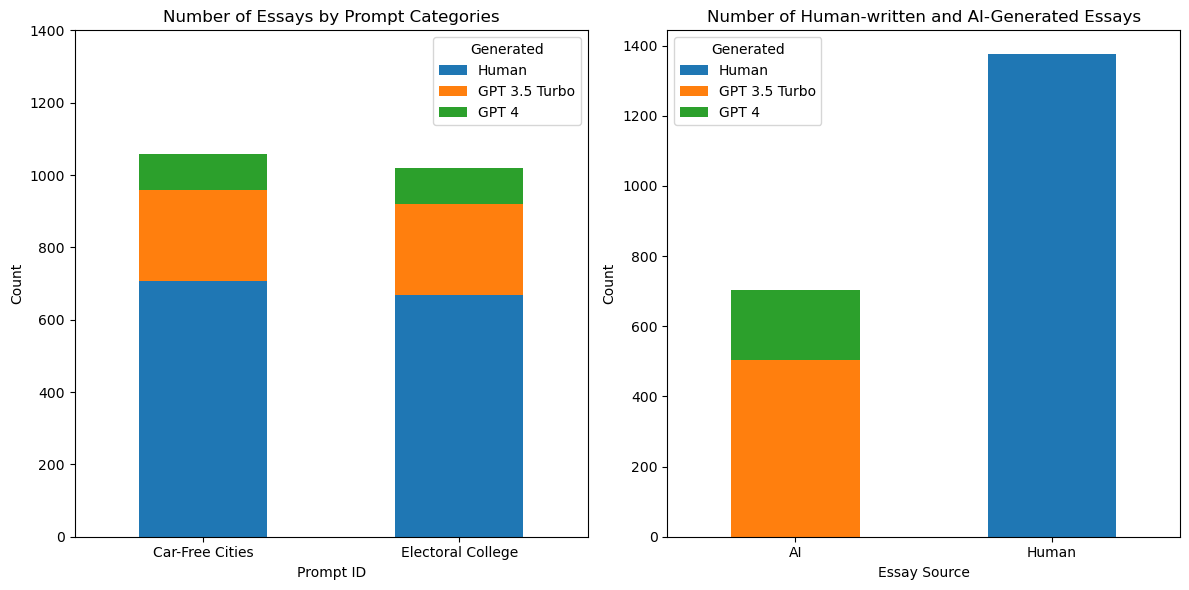

In [86]:
# Create mappings for 'prompt_id' and 'is_ai'
prompt_id_mapping = {0: 'Car-Free Cities', 1: 'Electoral College'}
is_ai_mapping = {0: 'Human', 1: 'AI'}

# Apply mappings directly in the groupby operation for 'prompt_id'
grouped_data_prompt = stacked_df.copy()
grouped_data_prompt['prompt_id'] = grouped_data_prompt['prompt_id'].map(prompt_id_mapping)
grouped_data_prompt = grouped_data_prompt.groupby(['prompt_id', 'generated']).size().reset_index(name='count')

# Apply mappings directly in the groupby operation for 'is_ai'
grouped_data_ai = stacked_df.copy()
grouped_data_ai['is_ai'] = grouped_data_ai['is_ai'].map(is_ai_mapping)
grouped_data_ai = grouped_data_ai.groupby(['is_ai', 'generated']).size().reset_index(name='count')

fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # Setup for subplots

# Plot for 'prompt_id'
grouped_data_prompt.pivot('prompt_id', 'generated', 'count').plot(kind='bar', stacked=True, ax=ax[0])
ax[0].set_xlabel('Prompt ID')
ax[0].set_ylabel('Count')
ax[0].set_title('Number of Essays by Prompt Categories')
ax[0].tick_params(axis='x', rotation=0)  # Adjusted for better label visibility
ax[0].legend(title='Generated', labels=['Human', 'GPT 3.5 Turbo', 'GPT 4'], loc='upper right')
ax[0].set_ylim(0, 1400)

# Plot for 'is_ai'
grouped_data_ai.pivot('is_ai', 'generated', 'count').plot(kind='bar', stacked=True, ax=ax[1])
ax[1].set_xlabel('Essay Source')
ax[1].set_ylabel('Count')
ax[1].set_title('Number of Human-written and AI-Generated Essays')
ax[1].tick_params(axis='x', rotation=0)
ax[1].legend(title='Generated', labels=['Human', 'GPT 3.5 Turbo', 'GPT 4'])

plt.tight_layout()
plt.show()

The bar graphs above show that the prompts are generally balanced, and we can see the distribution of AI-generated essays that belong to which generated AI model.

### Set Up Basic Functions and Conduct Average Semantic Similarity Feature Extraction
- Setting up the following:
    - evaluate_cohens_d
    - evaluate_hypothesis_test
    - process_text_and_calculate_similarity

In [87]:
# evaluate_cohens_d to have a function that returns the label of the effect size when conducting statistical analysis
def evaluate_cohens_d(d):
    abs_d = abs(d)  # Using absolute value for evaluation
    if abs_d < 0.2:
        return "There is a small effect size."
    elif abs_d < 0.5:
        return "There is a medium effect size."
    elif abs_d >= 0.8:
        return "There is a large effect size."
    else:  # Covering the range between 0.5 and 0.8
        return "There is a moderate effect size."

In [88]:
# evaluate_hypothesis_test to evaluate if we should reject H0 or fail to reject H0 when we do statistical analysis
def evaluate_hypothesis_test(p_val, alpha):
    """
    Evaluate the outcome of a hypothesis test based on the p-value and significance level.

    Args:
    p_val (float): The p-value obtained from the hypothesis test.
    alpha (float): The significance level.
    """  
    if p_val > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('p-value is less than %.2f, so it is a different distribution (reject H0)' % alpha)

In [89]:
# Load Spacy
nlp = spacy.load("en_core_web_lg")

data_df = stacked_df.copy()

# Make all of the text in dataframe lowercase
data_df['text'] = data_df['text'].str.lower()

In [90]:
data_df.head()

,id,prompt_id,text,generated,is_ai,prompt_and_is_ai
0,0059830c,0,cars. cars have been around since they became ...,0,0,Car-Free_and_Human
1,005db917,0,transportation is a large necessity in most co...,0,0,Car-Free_and_Human
2,008f63e3,0,"""america's love affair with it's vehicles seem...",0,0,Car-Free_and_Human
3,00940276,0,how often do you ride in a car? do you drive a...,0,0,Car-Free_and_Human
4,00c39458,0,cars are a wonderful thing. they are perhaps o...,0,0,Car-Free_and_Human


In [91]:
# process_text_and_calculate_similarity is a function to remove the stopwords and to calculate the 
# average semantic similarity score between words for a given text
def process_text_and_calculate_similarity(text):
    # Process text with Spacy with only making one single Spacy call for efficency
    doc = nlp(text)
    # Remove stopwords and punctuation in a single step, and get list of relevant tokens
    tokens = [token for token in doc if not token.is_stop and not token.is_punct]
    
    # Calculate similarity scores between words
    sims = []
    for i in range(len(tokens)):
        for j in range(i + 1, len(tokens)):
            if tokens[i].has_vector and tokens[j].has_vector:  # Check if both tokens have vectors
                similarity_score = tokens[i].similarity(tokens[j])
                sims.append(similarity_score)  # Append similarity score
    
    # Cleaned and processed text
    processed_text = ' '.join(token.text for token in tokens)
    # Average similarity per document, default to 0 if 'sims' is empty
    avg_similarity = np.mean(sims) if sims else 0
    
    return processed_text, avg_similarity

# Apply the function to each row in the DataFrame and create new columns for the processed text and average semantic similarity
data_df[['cw_text', 'avg_semantic_similarity']] = data_df['text'].apply(lambda x: pd.Series(process_text_and_calculate_similarity(x)))

# Display the first few rows of the DataFrame to verify the changes
data_df.head()

,id,prompt_id,text,generated,is_ai,prompt_and_is_ai,cw_text,avg_semantic_similarity
0,0059830c,0,cars. cars have been around since they became ...,0,0,Car-Free_and_Human,cars cars famous 1900s henry ford created buil...,0.197491
1,005db917,0,transportation is a large necessity in most co...,0,0,Car-Free_and_Human,transportation large necessity countries world...,0.228136
2,008f63e3,0,"""america's love affair with it's vehicles seem...",0,0,Car-Free_and_Human,america love affair vehicles cooling says elis...,0.264311
3,00940276,0,how often do you ride in a car? do you drive a...,0,0,Car-Free_and_Human,ride car drive motor vehicle work store mall t...,0.230147
4,00c39458,0,cars are a wonderful thing. they are perhaps o...,0,0,Car-Free_and_Human,cars wonderful thing worlds greatest advanceme...,0.219172


## Analysis - AI vs. Human General Comparison

### Do AI-generated essays stay on-topic to a greater degree than human-written essays?

Hypothesis (H1): AI-generated texts will have higher semantic similarity scores between words indicating that a text is more on-topic compared to human-written essays.

Null hypothesis (H0): There is no significant difference in the semantic similarity scores between words, which indicates whether a text is more on-topic, in AI-generated texts and human-written essays.

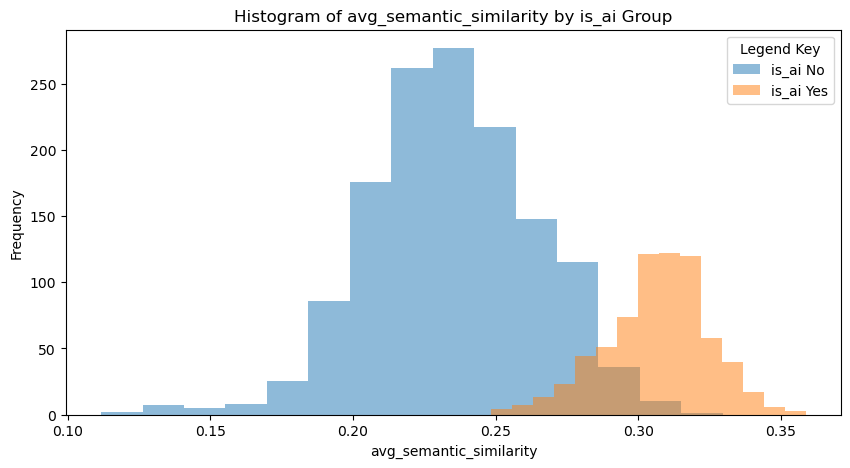

In [92]:
# First conduct visualizations on the column features to get a general understanding of the data
def plot_histograms(dataframe, group_col, value_cols):
    for col in value_cols:
        plt.figure(figsize=(10, 5))
        for key, grp in dataframe.groupby(group_col):
            label = 'is_ai Yes' if key == 1 else 'is_ai No'
            grp[col].plot(kind='hist', alpha=0.5, label=label, bins=15)
        plt.title(f'Histogram of {col} by is_ai Group')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.legend(title='Legend Key') 
        plt.show()

# avg_semantic_similarity is the average of each pair of words' semantic similarity in a document 
value_cols = ['avg_semantic_similarity']

# Create histograms
plot_histograms(data_df, 'is_ai', value_cols)

The above graphic shows the distribution of average semantic similarity scores between words for two groups of texts, differentiated by whether the text is AI-generated ("is_ai Yes") or human-written ("is_ai No"). From the histogram, we can observe that there are two distinct peaks, which suggests that AI-generated texts and human-written texts typically exhibit different levels of average semantic similarity between words where AI-generated texts generally have higher levels of average semantic similarity between words compare to human-written texts. The graphic also shows that both groups of texts look normally distributed.

### Explore Visualizations of Human vs. GPT 3.5 Turbo vs. GPT 4

Though the main focus of this analysis is on the *is_ai* group, I wanted to explore whether the various GPT models within this group exhibit bimodal characteristics, which will impact how I conduct my analysis.

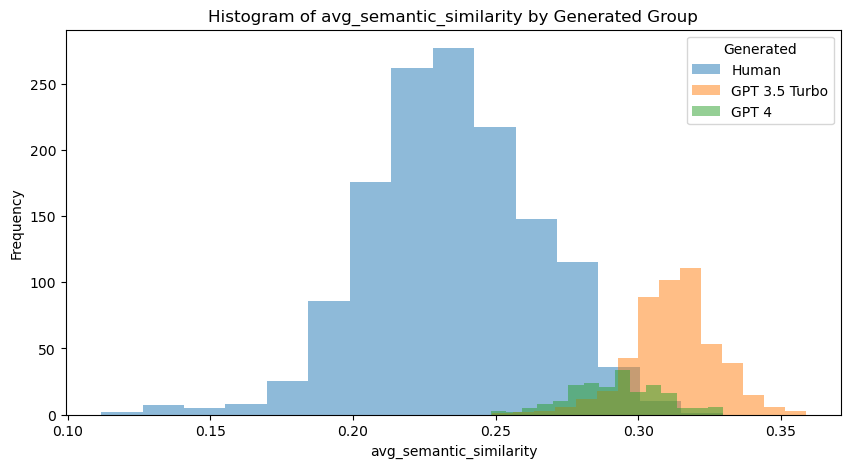

In [93]:
# Conduct visualizations on the different AI model types' average semantic similarity score between words
def plot_histograms(dataframe, group_col, value_cols):
    # provide the Human, GPT 3.5 Turbo, and  GPT 4 labels as group_labels for plotting
    group_labels = {0: 'Human', 1: 'GPT 3.5 Turbo', 2: 'GPT 4'}
    
    for col in value_cols:
        plt.figure(figsize=(10, 5))
        for key, grp in dataframe.groupby(group_col):
            label = group_labels.get(key, f'Group {key}')
            grp[col].plot(kind='hist', alpha=0.5, label=label, bins=15)
        plt.title(f'Histogram of {col} by Generated Group')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.legend(title='Generated', loc='upper right')
        plt.show()

value_cols = ['avg_semantic_similarity']

# Create histograms based on 'generated' group
plot_histograms(data_df, 'generated', value_cols)

Given the "Histogram of avg_semantic_similarity by Generated Group" plot above, we see that there are distinct peaks for texts generated by GPT 3.5 Turbo and GPT 4, which suggests there are differences in avg_semantic_similarity, but we also see that the distributions for the AI-generated texts overlap considerably. The overlap indicates that despite the variations among GPT 3.5 Turbo and GPT 4, the difference in avg_semantic_similarity is not substantial enough to warrant separate categorizations for the purpose of this analysis. Thus, it is reasonable to treat the outputs from GPT 3.5 Turbo and GPT 4 as a single, unified group representing AI-generated text for this particular analysis focusing on avg_semantic_similarity.

## AI vs. Human General Comparison - Statistical Analysis

To conduct the statistical analysis, we first need to divide our data into two distinct dataframes where one dataframe represents human-written essays while the other dataframe represents AI-generated essays. When performing comparative studies, we often need to perform normalization to ensure that the data is on a common scale or range to prevent the analysis from getting influenced by scale disparities or skewness.

To determine whether the datasets require normalization, we conducted skewness and Kurtosis to assess the symmetry and the tailedness of the distribution of data_df, human_df, and ai_df datasets. The skewness and Kurtosis measures show that all the datasets' avg_semantic_similarity values closely resemble a normal distribution. Given that the avg_semantic_similarity values for all datasets have similar ranges and generally have a normal distribution indicates that normalizing avg_semantic_similarity is not necessary for this analysis.

By also looking at the "Histogram of avg_semantic_similarity by is_ai Group" plot to determine that our data is normally distributed, we used the Bartlett's test to indicate what is the variance difference between the two independent groups. The Bartlett's test was necessary to determine whether the variances are equal or not as it influences whether we can use a two-sample t-test or a Welch's t-test. The Bartlett's test showed that there is statistical evidence to suggest that the variances of the two groups are different, so we were able to use the Welch's t-test. 

The Welch's t-test is designed to compare the means of two independent groups that follow a normal distribution where the equal variances assumption between the independent groups is not valid. After conducting the Welch's t-test to get the t-statistic and p-value, we used Cohen's D to evaluate effect size.


Welch's T-Test Formula:

$$
t = \frac{\bar{X}_1 - \bar{X}_2}{\sqrt{\frac{s^2_1}{n_1} + \frac{s^2_2}{n_2}}}
$$

Where:
- $t$ is the test statistic,
- $\bar{X}_1$ and $\bar{X}_2$ are the sample means of the two groups,
- $s^2_1$ and $s^2_2$ are the sample variances of the two groups,
- $n_1$ and $n_2$ are the sample sizes of the two groups.

The degrees of freedom for the test, used to determine the critical value from the t-distribution, are calculated using the Welch-Satterthwaite equation:

$$
df = \frac{\left(\frac{s^2_1}{n_1} + \frac{s^2_2}{n_2}\right)^2}{\frac{\left(\frac{s^2_1}{n_1}\right)^2}{n_1 - 1} + \frac{\left(\frac{s^2_2}{n_2}\right)^2}{n_2 - 1}}
$$



In [94]:
# Prepare data to create two sub groups based on whether a text is AI-generated or human-written
human_df = data_df[data_df['is_ai'] == 0] 
ai_df = data_df[data_df['is_ai'] == 1] 

# Tables to use going forward for this statistical analysis are human_df and ai_df

### Skewness and Kurtosis for AI vs. Human General Comparison
For all three datasets (data_df, human_df, and ai_df), we see that the skewness metrics are negative and overall close to zero, which means that the distribution of each dataset's avg_semantic_similarity distribution is nearly symmetric. 

For data_df's avg_semantic_similarity values, we see that the Kurtosis is slightly less than 3, which indicates that the distribution is a bit flatter than a normal distribution. For both human_df and ai_df's avg_semantic_similarity values, we see that they have Kurtosis values slightly greater than three, which indicates they have a slightly more peaked distributions than a normal distribution. 

Since the deviations are overall minor for both the skewness and Kurtosis metrics, we can assume that all of our datasets' avg_semantic_similarity values closely resemble a normal distribution, which further indicates that normalizing avg_semantic_similarity is not necessary for this analysis.

In [95]:
# Calculate skewness and kurtosis for the overall dataset
overall_skewness = skew(data_df['avg_semantic_similarity'])
overall_kurtosis = kurtosis(data_df['avg_semantic_similarity'], fisher=False)

# Calculate skewness and kurtosis for the human_df subset
human_skewness = skew(human_df['avg_semantic_similarity'])
human_kurtosis = kurtosis(human_df['avg_semantic_similarity'], fisher=False)

# Calculate skewness and kurtosis for the ai_df subset
ai_skewness = skew(ai_df['avg_semantic_similarity'])
ai_kurtosis = kurtosis(ai_df['avg_semantic_similarity'], fisher=False)

# Print the results
print(f"Overall Dataset (data_df): Skewness = {overall_skewness:.3f}, Kurtosis = {overall_kurtosis:.3f}")
print(f"Human Dataset (human_df): Skewness = {human_skewness:.3f}, Kurtosis = {human_kurtosis:.3f}")
print(f"AI Dataset (ai_df): Skewness = {ai_skewness:.3f}, Kurtosis = {ai_kurtosis:.3f}")

# Results show that the datasets closely resemble a normal distribution

Overall Dataset (data_df): Skewness = -0.040, Kurtosis = 2.241
Human Dataset (human_df): Skewness = -0.209, Kurtosis = 3.547
AI Dataset (ai_df): Skewness = -0.331, Kurtosis = 3.236


### Bartlett's test with Welch's t-test and Effect Size Calculations for AI vs. Human General Comparison
- Confirmed with the Bartlett's test to use a Welch's t-test to determine if there is any statistically significant difference in the mean semantic similarity scores between words in AI-generated essays compare to human-written essays.

In [96]:
# Perform Bartlett's test for equal variances on avg_semantic_similarity

bartlett_stat, bartlett_p = stats.bartlett(
    human_df['avg_semantic_similarity'], 
    ai_df['avg_semantic_similarity']
)
print('Bartlett\'s test statistic= %.3f, p= %.3f' % (bartlett_stat, bartlett_p))

alpha = 0.05

# Interpret the p-value
if bartlett_p > alpha:
    print(f"Bartlett's test p-value is greater than the significance level (p = {bartlett_p:.3f}).")
    print("Fail to reject the null hypothesis of equal variances. It is appropriate to use independent t-test (two-sampled t-test).")
else:
    print(f"Bartlett's test p-value is less than or equal to the significance level (p = {bartlett_p:.3f}).")
    print("Reject the null hypothesis of equal variances. It is appropriate to use Welch's t-test.")

# The null hypothesis for Bartlett's test is that there is no difference in variances between the groups.
# Test statistic: It represents how much the variances of the groups differ. 
# Since p-value is 0, I reject the null hypothesis of the Bartlett's test, which suggests that there is a significant 
# difference in variances between the two groups. This indicates that we should use the Welch's t-test.

Bartlett's test statistic= 191.663, p= 0.000
Bartlett's test p-value is less than or equal to the significance level (p = 0.000).
Reject the null hypothesis of equal variances. It is appropriate to use Welch's t-test.


In [97]:
# Perform Welch's t-test

t_stat, p_val = stats.ttest_ind(
    human_df['avg_semantic_similarity'], 
    ai_df['avg_semantic_similarity'], equal_var=False
)
print('Welch T-statistic= %.3f, p= %.3f' % (t_stat, p_val))

alpha = 0.05

evaluate_hypothesis_test(p_val, alpha)

Welch T-statistic= -68.710, p= 0.000
p-value is less than 0.05, so it is a different distribution (reject H0)


In [98]:
# Conduct Cohen's D for effect size
# Calculate means
mean_human = np.mean(human_df['avg_semantic_similarity'])
mean_ai = np.mean(ai_df['avg_semantic_similarity'])

# Calculate standard deviations
std_human = np.std(human_df['avg_semantic_similarity'], ddof=1)
std_ai = np.std(ai_df['avg_semantic_similarity'], ddof=1)

# Calculate the sample sizes
n_human = len(human_df['avg_semantic_similarity'])
n_ai = len(ai_df['avg_semantic_similarity'])

# Calculate the pooled standard deviation (Cohen's d denominator)
pooled_std = np.sqrt(((n_human - 1) * std_human**2 + (n_ai - 1) * std_ai**2) / (n_human + n_ai - 2))

cohens_d = (mean_ai - mean_human) / pooled_std

print(f"Cohen's d = {cohens_d:.3f}")

# Get the descriptive label for the effect size
effect_size_description = evaluate_cohens_d(cohens_d)
print(effect_size_description)

# When calculating Cohen's D, the positive or negative value represents direction
# A positive value means that AI-generated texts' mean avg_semantic_similarity is higher than human-written texts' mean
# avg_semantic_similarity score. A negative value means that AI-generated texts' mean avg_semantic_similarity is smaller
# than human-written texts' mean avg_semantic_similarity score.

# Based on the positive value we get below, this means that AI-generated texts' mean avg_semantic_similarity is higher than
# human-written texts' mean avg_semantic_similarity score.

Cohen's d = 2.751
There is a large effect size.


#### Results for AI vs. Human General Comparison:
We reject the null hypothesis (H0) after seeing the p-value along with how there is a large effect size. Since we also have a positive Cohen's D value, this indicates that the mean of the AI-generated texts' semantic similarity scores between words is higher than that of the mean human-generated essays' semantic similarity scores between words. Thus, we fail to reject our hypothesis (H1) since we have evidence to believe that generative AI has higher average semantic similarity scores between words indicating that a AI-generated text is more on-topic compared to human-written essays.

### AI vs. Human General Comparison - Summary

The statistically significant difference in the average semantic similarity scores between words when comparing AI generated essays to human-written essays in general provides evidence that there is a linguistic characteristic difference between the two groups, particularly indicating that AI-generated texts are more likely to stay on-topic compared to human written essays. Thus, we can consider using average semantic similarity between words as a feature when doing an AI detection classifier in the future.

## Post-Hoc Analysis - AI vs. Human Prompt Split General Comparison

This is a post-hoc analysis to examine the average semantic similarity between words distribution for each essay prompt's set of AI and human-written essays to identify if there are any distribution differences between the two groups for each essay prompt. 

The motivation to conduct a post-hoc analysis is to see if the statistically significant results found in AI vs. Human general comparison section still hold when accounting for specific prompts as specific sub-groups. By analyzing these sub-groups, we can examine whether certain prompts may inherently lead to more or less semantic similarity between words for each text, so we can observe whether the statistically significant results found in AI vs. Human general comparison section is consistent across different prompts or if there are specific prompts where AI and human-written texts perform more distinctly for semantic similarity between words.

For this section, our hypothesis (H1) is the following:
There is a significant difference in the semantic similarity scores between words, which reflects the degree to how well an essay stays on-topic, in AI-generated texts and human-written essays for a given specific prompt.

Null hypothesis (H0): There is no significant difference in the semantic similarity scores between words, which indicates whether a text is more on-topic, in AI-generated texts and human-written essays for a given specific prompt.

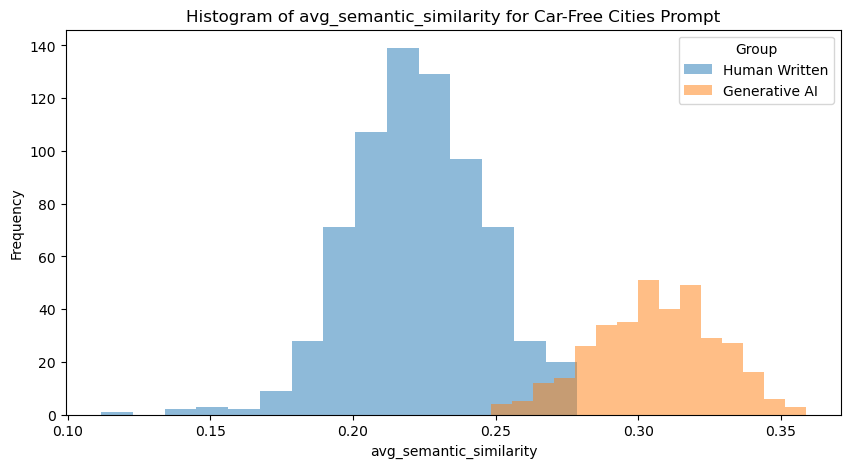

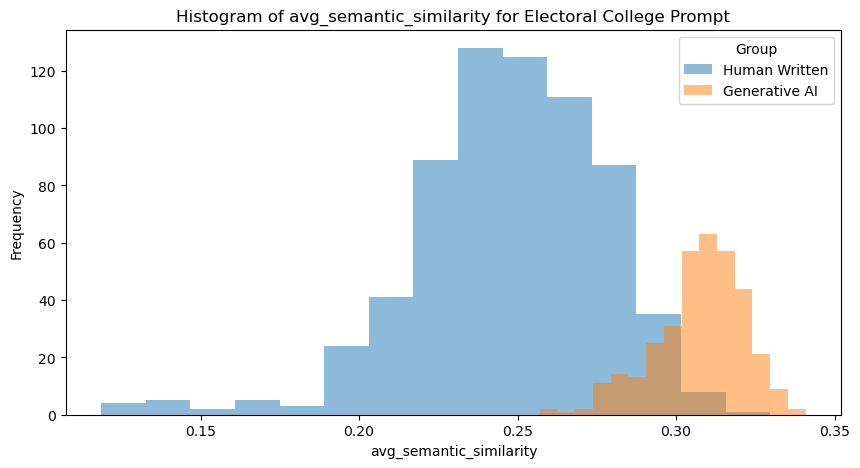

In [99]:
def plot_histograms_by_prompt(dataframe, prompt_col, ai_col, value_col):
    # Define histogram labels
    ai_labels = {0: 'Human Written', 1: 'Generative AI'}
    prompt_names = {0: 'Car-Free Cities', 1: 'Electoral College'}
    
    for prompt_id in dataframe[prompt_col].unique():
        # Filter the dataframe for the current prompt
        prompt_df = dataframe[dataframe[prompt_col] == prompt_id]
        
        # Get the descriptive prompt name
        prompt_name = prompt_names.get(prompt_id, 'Unknown Prompt')
        
        # Plot the histogram for the value_col
        plt.figure(figsize=(10, 5))
        # Within a prompt sub-group, we are now focusing on getting the human vs. AI groups
        for ai_key in prompt_df[ai_col].unique():
            ai_df = prompt_df[prompt_df[ai_col] == ai_key]
            label = ai_labels[ai_key]
            ai_df[value_col].hist(alpha=0.5, label=label, bins=15, grid = False)
        
        plt.title(f'Histogram of {value_col} for {prompt_name} Prompt')
        plt.xlabel(value_col)
        plt.ylabel('Frequency')
        plt.legend(title='Group') 
        plt.show()

# Call the function with the avg_semantic_similarity column to get the avg_semantic_similarity for each sub-group plot
plot_histograms_by_prompt(data_df, 'prompt_id', 'is_ai', 'avg_semantic_similarity')

In the above graphics, the first graphic illustrates the distribution of average semantic similarity scores between words for texts in response to the "Car-Free Cities" prompt while the second graphic illustrates the distribution of average semantic similarity scores between words for texts in response to the "Electoral College" prompt. Both histograms indicate two groups human-written texts (blue) and AI-generated texts (orange) where there are two distinct peaks for each graphic. This suggests that AI-generated texts and human-written texts typically exhibit different levels of average semantic similarity between words where AI-generated texts generally have higher levels of average semantic similarity between words compare to human-written texts, even accounting for different prompts as different sub-groups. The graphic also shows that all of the sub-groups of texts look normally distributed.

## Post-Hoc Analysis - AI vs. Human Prompt Split General Comparison - Statistical Analysis

To conduct the post-hoc statistical analysis, I first need to divide our data_df into four distinct dataframes where two dataframes represent the "Car-Free Cities" prompt and the other two dataframes represent the "Electoral College" prompt. For each of these prompt groupings, we need to create a dataframe that represents human-written essays while the other dataframe represents AI-generated essays. This will result in having four distinct dataframes for the post-hoc analysis. Similar to the previous analysis, we often need to perform normalization to ensure that the data is on a common scale or range to prevent the analysis from getting influenced by scale disparities or skewness, but the skewness and Kurtosis metrics indicate that all of the four datasets' avg_semantic_similarity values closely resemble a normal distribution. Given that the avg_semantic_similarity values for all the datasets have similar ranges and generally have a normal distribution, we can presume that normalizing avg_semantic_similarity is not necessary in the post-hoc analysis.

By also looking at each prompt's histogram to determine that our data is normally distributed, I used the Bartlett's test on each prompt sub-group to indicate what is the variance difference between the two independent groups. The Bartlett's test was necessary to determine whether the variances are equal or not as it influences whether I can use a two-sample t-test or a Welch's t-test. For the "Car-Free Cities" prompt, the Bartlett's test showed that there is statistical evidence to suggest that the variances of the AI-generated and human-written essays are the same, so we used the two-Sampled t-test. For the "Electoral College" prompt, the Bartlett's test showed that there is statistical evidence to suggest that the variances of the AI-generated and human-written essays are different, so we were able to use the Welch's t-test. After conducting the appropriate statistical test for both prompt sub-groups, we used Cohen's D to evaluate effect size.

Independent T-Test Formula (assuming equal variances):

$$
t = \frac{\bar{X}_1 - \bar{X}_2}{\sqrt{s^2_p \left(\frac{1}{n_1} + \frac{1}{n_2}\right)}}
$$

Where:
- $t$ is the test statistic,
- $\bar{X}_1$ and $\bar{X}_2$ are the sample means of the two groups,
- $s^2_p$ is the pooled variance,
- $n_1$ and $n_2$ are the sample sizes of the two groups.

The pooled variance is calculated as:

$$
s^2_p = \frac{(n_1-1)s^2_1+(n_2-1)s^2_2}{n_1+n_2-2}
$$

And the degrees of freedom for the independent t-test are calculated as:

$$
df = n_1 + n_2 - 2
$$

Due to concerns of a type I error due to family-wise error rate that would need to have a correction after running many t-tests, we also performed a multiple linear regression analysis where we create dummy variables as our categorical predictors. The categorical predictors or independent variables in the multiple linear regression are *is_ai* and *prompt_id*, while our dependent variable is *avg_semantic_similarity*. After conducting the multiple linear regression analysis, we also examined the interaction effect between *is_ai* and *prompt_id*.

In [100]:
# Prepare data to do the avg_semantic_similarity for each dataframe, so I need to create 4 dataframes 
# as it is 2 groups for each prompt.
car_free_human_df = data_df[data_df['prompt_and_is_ai'] == 'Car-Free_and_Human'] 
car_free_ai_df = data_df[data_df['prompt_and_is_ai'] == 'Car-Free_and_AI'] 

electoral_human_df = data_df[data_df['prompt_and_is_ai'] == 'Electoral_and_Human'] 
electoral_ai_df = data_df[data_df['prompt_and_is_ai'] == 'Electoral_and_AI'] 

# Tables to use going forward for this statistical analysis are car_free_human_df, car_free_ai_df, 
# electoral_human_df, and electoral_ai_df.

### Skewness and Kurtosis for AI vs. Human General Comparison
For all four datasets (car_free_human_df, car_free_ai_df, electoral_human_df, and electoral_ai_df), we see that the skewness metrics are negative and overall close to zero, which means that the distribution of each dataset's avg_semantic_similarity distribution is nearly symmetric.

Regarding kurtosis, car_free_human_df, electoral_human_df, and electoral_ai_df exhibit values above three, signifying avg_semantic_similarity value distributions with peaks that are slightly more pronounced compared to a standard normal distribution. This implies a minor increase in the prevalence of scores around the mean, coupled with heavier tails that may contain more outliers than expected under normality. Conversely, the car_free_ai_df's avg_semantic_similarity values distribution shows a kurtosis slightly below three, indicating a flatter peak relative to a normal distribution, which suggests a broader spread of the central scores and fewer outliers.

Since the deviations are overall minor for both the skewness and Kurtosis metrics, we can assume that all four datasets' avg_semantic_similarity values closely resemble a normal distribution, which further indicates that normalizing avg_semantic_similarity is not necessary for this analysis.

Despite these observations, the deviations from the perfect normality metrics (skewness and kurtosis) are overall minor for both skewness and kurtosis across all datasets. This consistency across both prompts underscores that the avg_semantic_similarity values for each dataset closely resembles a normal distribution. Consequently, the similarity to normal distribution characteristics indicates that normalizing avg_semantic_similarity for each of the four datasets in the ad-hoc analysis is unnecessary.

In [101]:
# Calculate skewness and kurtosis for the car_free_human_df subset
car_free_human_skewness = skew(car_free_human_df['avg_semantic_similarity'])
car_free_human_kurtosis = kurtosis(car_free_human_df['avg_semantic_similarity'], fisher=False)

# Calculate skewness and kurtosis for the car_free_ai_df subset
car_free_ai_skewness = skew(car_free_ai_df['avg_semantic_similarity'])
car_free_ai_kurtosis = kurtosis(car_free_ai_df['avg_semantic_similarity'], fisher=False)

# Calculate skewness and kurtosis for the electoral_human_df subset
electoral_human_skewness = skew(electoral_human_df['avg_semantic_similarity'])
electoral_human_kurtosis = kurtosis(electoral_human_df['avg_semantic_similarity'], fisher=False)

# Calculate skewness and kurtosis for the electoral_ai_df subset
electoral_ai_skewness = skew(electoral_ai_df['avg_semantic_similarity'])
electoral_ai_kurtosis = kurtosis(electoral_ai_df['avg_semantic_similarity'], fisher=False)

# Print the results
print(f"Car-free Human Dataset: Skewness = {car_free_human_skewness:.3f}, Kurtosis = {car_free_human_kurtosis:.3f}")
print(f"Car-free AI Dataset: Skewness = {car_free_ai_skewness:.3f}, Kurtosis = {car_free_ai_kurtosis:.3f}")
print(f"Electoral Human Dataset: Skewness = {electoral_human_skewness:.3f}, Kurtosis = {electoral_human_kurtosis:.3f}")
print(f"Electoral AI Dataset: Skewness = {electoral_ai_skewness:.3f}, Kurtosis = {electoral_ai_kurtosis:.3f}")

# Results show that the datasets closely resemble a normal distribution

Car-free Human Dataset: Skewness = -0.225, Kurtosis = 3.854
Car-free AI Dataset: Skewness = -0.150, Kurtosis = 2.666
Electoral Human Dataset: Skewness = -0.829, Kurtosis = 4.817
Electoral AI Dataset: Skewness = -0.661, Kurtosis = 3.455


### Car-Free Cities Prompt Analysis Section

#### Bartlett's test with Two-Sampled t-test and Effect Size Calculations for Car-Free Cities Prompt
- Confirmed with the Bartlett's test to use a two-sampled t-test to determine if there is any statistically significant difference in the mean semantic similarity scores between words in AI-generated essays compare to human-written essays within the "Car-Free Cities" prompt.

In [102]:
# Perform Bartlett's test for equal variances
bartlett_stat, bartlett_p = stats.bartlett(
    car_free_human_df['avg_semantic_similarity'], 
    car_free_ai_df['avg_semantic_similarity']
)
print('Bartlett\'s test statistic= %.3f, p= %.3f' % (bartlett_stat, bartlett_p))


alpha = 0.05

# Interpret the p-value
if bartlett_p > alpha:
    print(f"Bartlett's test p-value is greater than the significance level (p = {bartlett_p:.3f}).")
    print("Fail to reject the null hypothesis of equal variances. It is appropriate to use independent t-test (two-sampled t-test).")
else:
    print(f"Bartlett's test p-value is less than or equal to the significance level (p = {bartlett_p:.3f}).")
    print("Reject the null hypothesis of equal variances. It is appropriate to use Welch's t-test.")

# The null hypothesis for Bartlett's test is that there is no difference in variances between the groups.
# Test statistic: It represents how much the variances of the groups differ. 
# Since p-value is 0.105, I fail to reject the null hypothesis of the Bartlett's test, which suggests that there is
# a significant difference in variances between the two groups. This indicates that we should use the two-sampled t-test.

Bartlett's test statistic= 2.459, p= 0.117
Bartlett's test p-value is greater than the significance level (p = 0.117).
Fail to reject the null hypothesis of equal variances. It is appropriate to use independent t-test (two-sampled t-test).


In [103]:
# Perform independent t-test/the two-sampled t-test.
t_stat, p_val = stats.ttest_ind(
    car_free_human_df['avg_semantic_similarity'], 
    car_free_ai_df['avg_semantic_similarity'], equal_var=True
)
print(f"Independent t-test statistic = {t_stat:.3f}, p-value = {p_val:.3f}")

alpha = 0.05

evaluate_hypothesis_test(p_val, alpha)

Independent t-test statistic = -56.500, p-value = 0.000
p-value is less than 0.05, so it is a different distribution (reject H0)


In [104]:
# Conduct Cohen's D for effect size
# Calculate means
mean_human = np.mean(car_free_human_df['avg_semantic_similarity'])
mean_ai = np.mean(car_free_ai_df['avg_semantic_similarity'])

# Calculate standard deviations
std_human = np.std(car_free_human_df['avg_semantic_similarity'], ddof=1)
std_ai = np.std(car_free_ai_df['avg_semantic_similarity'], ddof=1)

# Calculate the sample sizes
n_human = len(car_free_human_df['avg_semantic_similarity'])
n_ai = len(car_free_ai_df['avg_semantic_similarity'])

# Calculate the pooled standard deviation (Cohen's d denominator)
pooled_std = np.sqrt(((n_human - 1) * std_human**2 + (n_ai - 1) * std_ai**2) / (n_human + n_ai - 2))

cohens_d = (mean_ai - mean_human) / pooled_std

print(f"Cohen's d = {cohens_d:.3f}")

# Get the descriptive label for the effect size
effect_size_description = evaluate_cohens_d(cohens_d)
print(effect_size_description)

# When calculating Cohen's D, the positive or negative value represents direction
# A positive value means that AI-generated texts' mean avg_semantic_similarity is higher than human-written texts' mean
# avg_semantic_similarity score. A negative value means that AI-generated texts' mean avg_semantic_similarity is smaller
# than human-written texts' mean avg_semantic_similarity score.

# Based on the positive value we get below, this means that AI-generated texts' mean avg_semantic_similarity is higher than
# human-written texts' mean avg_semantic_similarity score.

Cohen's d = 3.689
There is a large effect size.


#### Results for AI vs. Human General Comparison within Car-Free Cities Prompt:
We reject the null hypothesis (H0) after seeing the p-value along with a large effect size. Since we also have a positive Cohen's D value, this indicates that the mean of the AI-generated texts' semantic similarity scores between words is higher than that of the mean human-generated essays' semantic similarity scores between words for the "Car-Free Cities" prompt. Thus, we fail to reject our hypothesis (H1) for the "Car-Free Cities" prompt sub-group since we have evidence to believe that generative AI and human-written essays will have different average semantic similarity scores between words, which indicates that there is a difference between the two groups in terms of how well an essay stays on-topic.

### Electoral College Prompt Analysis Section

#### Bartlett's test with Welch's t-test and Effect Size Calculations for Electoral College Prompt
- Confirmed with the Bartlett's test to use a Welch's t-test to determine if there is any statistically significant difference in the mean semantic similarity scores between words in AI-generated essays compare to human-written essays within the "Electoral College" prompt.

In [105]:
# Perform Bartlett's test for equal variances
bartlett_stat, bartlett_p = stats.bartlett(
    electoral_human_df['avg_semantic_similarity'], 
    electoral_ai_df['avg_semantic_similarity']
)
print('Bartlett\'s test statistic= %.3f, p= %.3f' % (bartlett_stat, bartlett_p))


alpha = 0.05

# Interpret the p-value
if bartlett_p > alpha:
    print(f"Bartlett's test p-value is greater than the significance level (p = {bartlett_p:.3f}).")
    print("Fail to reject the null hypothesis of equal variances. It is appropriate to use independent t-test (two-sampled t-test).")
else:
    print(f"Bartlett's test p-value is less than or equal to the significance level (p = {bartlett_p:.3f}).")
    print("Reject the null hypothesis of equal variances. It is appropriate to use Welch's t-test.")


# The null hypothesis for Bartlett's test is that there is no difference in variances between the groups.
# Test statistic: It represents how much the variances of the groups differ. 
# Since p-value is 0, I reject the null hypothesis of the Bartlett's test, which suggests that there is a significant 
# difference in variances between the two groups. This indicates that we should use the Welch's t-test.

Bartlett's test statistic= 214.958, p= 0.000
Bartlett's test p-value is less than or equal to the significance level (p = 0.000).
Reject the null hypothesis of equal variances. It is appropriate to use Welch's t-test.


In [106]:
# Perform Welch's t-test

t_stat, p_val = stats.ttest_ind(
    electoral_human_df['avg_semantic_similarity'], 
    electoral_ai_df['avg_semantic_similarity'], equal_var=False
)
print('Welch T-statistic= %.3f, p= %.3f' % (t_stat, p_val))

alpha = 0.05

evaluate_hypothesis_test(p_val, alpha)

Welch T-statistic= -43.476, p= 0.000
p-value is less than 0.05, so it is a different distribution (reject H0)


In [107]:
# Conduct Cohen's D for effect size
# Calculate means
mean_human = np.mean(electoral_human_df['avg_semantic_similarity'])
mean_ai = np.mean(electoral_ai_df['avg_semantic_similarity'])

# Calculate standard deviations
std_human = np.std(electoral_human_df['avg_semantic_similarity'], ddof=1)
std_ai = np.std(electoral_ai_df['avg_semantic_similarity'], ddof=1)

# Calculate the sample sizes
n_human = len(electoral_human_df['avg_semantic_similarity'])
n_ai = len(electoral_ai_df['avg_semantic_similarity'])

# Calculate the pooled standard deviation (Cohen's d denominator)
pooled_std = np.sqrt(((n_human - 1) * std_human**2 + (n_ai - 1) * std_ai**2) / (n_human + n_ai - 2))

cohens_d = (mean_ai - mean_human) / pooled_std

print(f"Cohen's d = {cohens_d:.3f}")

# Get the descriptive label for the effect size
effect_size_description = evaluate_cohens_d(cohens_d)
print(effect_size_description)

# When calculating Cohen's D, the positive or negative value represents direction
# A positive value means that AI-generated texts' mean avg_semantic_similarity is higher than human-written texts' mean
# avg_semantic_similarity score. A negative value means that AI-generated texts' mean avg_semantic_similarity is smaller
# than human-written texts' mean avg_semantic_similarity score.

# Based on the positive value we get below, this means that AI-generated texts' mean avg_semantic_similarity is higher than
# human-written texts' mean avg_semantic_similarity score.

Cohen's d = 2.340
There is a large effect size.


#### Results for AI vs. Human General Comparison within Electoral College Prompt:
We reject the null hypothesis (H0) after seeing the p-value along with a large effect size. Since we also have a positive Cohen's D value, this indicates that the mean of the AI-generated texts' semantic similarity scores between words is higher than that of the mean human-generated essays' semantic similarity scores between words for the "Electoral College" prompt. Thus, we fail to reject our hypothesis (H1) for the "Electoral College" prompt sub-group since we have evidence to believe that generative AI and human-written essays will have different average semantic similarity scores between words, which indicates that there is a difference between the two groups in terms of how well an essay stays on-topic.

### Multiple Linear Regression Analysis Section

Since the previous analysis above ran many t-tests, there is a potential type I error due to family-wise error rate that would need to have a correction. To mitigate this issue, we performed a multiple linear regression analysis where we create dummy variables as our categorical predictors. The categorical predictors or independent variables in the multiple linear regression are *is_ai* and *prompt_id*, while our dependent variable is *avg_semantic_similarity*. After conducting the multiple linear regression analysis, we also created a linear regression plot and examined the interaction effect between *is_ai* and *prompt_id*. The findings in this section further add additional depth to the results found in the Car-Free Cities Prompt Analysis Section and Electoral College Prompt Analysis Section.

In [108]:
# Create a multiple linear regression model using two predictors: is_ai and prompt_id
# Since is_ai and prompt_id are already both in 0/1 format, they are essentially already dummy variables, so no further
# transformation is needed to create additional dummy variable for is_ai and prompt_id

# Include the binary variables directly as not needed to create additional dummy variables in this situation
X = data_df[['is_ai', 'prompt_id']]
# Add a constant term to the predictors
X = sm.add_constant(X)  

# Setting the outcome variable as avg_semantic_similarity, which is our dependent variable in this statistical model
Y = data_df['avg_semantic_similarity']

# Fit the model using Ordinary Least Squares (OLS)
model = sm.OLS(Y, X).fit()

# Print the model's summary
print(model.summary())

                               OLS Regression Results                              
Dep. Variable:     avg_semantic_similarity   R-squared:                       0.669
Model:                                 OLS   Adj. R-squared:                  0.668
Method:                      Least Squares   F-statistic:                     2093.
Date:                     Tue, 23 Apr 2024   Prob (F-statistic):               0.00
Time:                             11:32:38   Log-Likelihood:                 4743.3
No. Observations:                     2078   AIC:                            -9481.
Df Residuals:                         2075   BIC:                            -9464.
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

The multiple linear regression analysis indicates that approximately 66.9% of the variability in average semantic similarity scores can be accounted for by the model, which includes *is_ai* and *prompt_id* as predictor variables. This substantial proportion of explained variance signifies that these two factors are major contributors to the differences in average semantic similarity. The Adjusted R-squared value, at 66.8%, reaffirms the model's strength, confirming that the number of predictors used does not excessively influence the model’s explanatory power. The overall statistical significance of the model is confirmed by an F-statistic of 2093.0, with an associated p-value approaching zero. This result effectively rejects the null hypothesis that a model without the predictors is_ai and prompt_id would be sufficient to explain the observed variance in semantic similarity scores within the dataset. Thus, the inclusion of AI authorship and prompt identification significantly impacts the average semantic similarity between words scores observed in our dataset.

This can be seen in how the coefficient for *is_ai*, which tells us about the difference in *average semantic similarity* when the text is AI-generated (*is_ai* is 1) as opposed to human-written (*is_ai* is 0), controlling for the prompt. The coefficient at 0.0716 suggests that AI-generated texts have a higher average semantic similarity than human-written texts, and the p-value of < 0.05 indicates that when the effect of the prompt is statistically controlled for, AI authorship is linked to a consistent increase in average semantic similarity between words.

Similarity for the *prompt_id* coefficient, it shows the difference in average semantic similarity between words for prompt 1 (the electoral college prompt) compared to the reference prompt (prompt 0, which is about car-free cities) when controlling for authorship. The coefficient of 0.0170 suggests that texts responding to the electoral college prompt have slightly higher average semantic similarity than those responding to car-free cities prompt. Since the p-value is close to 0, this indicates that when the effect of authorship is statistically controlled for, electoral college prompt is linked to a consistent small increase in average semantic similarity between words.

In [109]:
# Get the model's parameters (intercept and coefficients)
params = model.params

# Create the linear regression equation for visibility
regression_equation = f"avg_semantic_similarity = {params['const']:.4f} "
regression_equation += f"+ ({params['is_ai']:.4f} * is_ai) "
regression_equation += f"+ ({params['prompt_id']:.4f} * prompt_id)"

print("The linear regression equation is:")
print(regression_equation)

The linear regression equation is:
avg_semantic_similarity = 0.2264 + (0.0716 * is_ai) + (0.0170 * prompt_id)


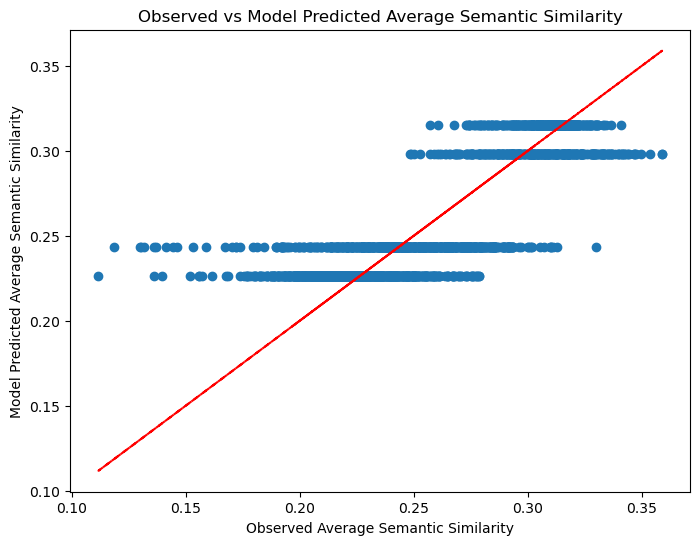

In [110]:
# Create a linear regression plot based on the multiple linear regression model
plt.figure(figsize=(8, 6))
plt.scatter(Y, model.fittedvalues)  # Plot observed vs. predicted values
plt.plot(Y, Y, 'r--')  # Add a reference line showing where observed=predicted
# X-axis shows the observed values
plt.xlabel('Observed Average Semantic Similarity')
# Y-axis shows the predicted values from the model
plt.ylabel('Model Predicted Average Semantic Similarity')  
plt.title('Observed vs Model Predicted Average Semantic Similarity')
plt.show()

The scatter plot illustrates the relationship between the observed average semantic similarity scores between words (indicated on the x-axis) and the scores predicted by the multiple linear regression model (indicated on the y-axis). The distinct horizontal banding of the data points suggests the existence of discrete groupings within our data. The groupings most likely correspond to the combinations of our two binary predictors: *is_ai*, indicating whether the text was generated by AI or human-written, and *prompt_id*, representing which of two prompts the essay is responding to.

The red dashed line represents the line of perfect prediction, where a point on this line indicates an exact match between the model's prediction and the actual observation. While not all points lie on this line, many points cluster around it, which demonstrates the model's efficacy in predicting average semantic similarity scores between words based on our two predictor variables.

We look at what the specific groupings refer to in the graphic below.

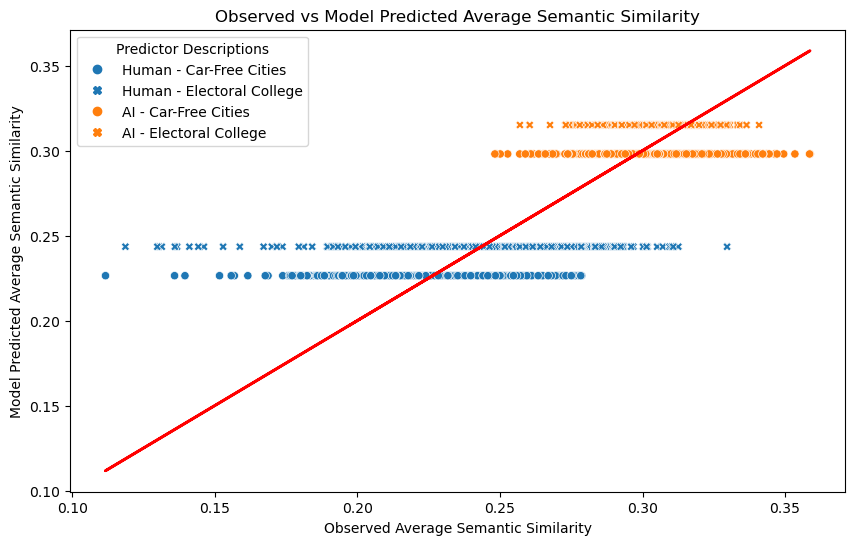

In [111]:
# Create a dataframe called graphic for plotting that includes the predicted values
graphic = data_df.copy()
# Create the predicted_semantic_similarity for graphing from the model
graphic['predicted_semantic_similarity'] = model.fittedvalues

# Plot it where is_ai is the color and we get the point style as prompt_id to see the specific bands.
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x='avg_semantic_similarity', y='predicted_semantic_similarity',
                          hue='is_ai', style='prompt_id', data=graphic, palette=['#1f77b4', '#ff7f0e'])

# Add the red reference line showing where observed=predicted
plt.plot(Y, Y, 'r-', linewidth=2)

# Label the axes and title
plt.xlabel('Observed Average Semantic Similarity')
plt.ylabel('Model Predicted Average Semantic Similarity')  
plt.title('Observed vs Model Predicted Average Semantic Similarity')

# Define legend group combinations
human_carfree = mlines.Line2D([], [], color='#1f77b4', marker='o', linestyle='None', label='Human - Car-Free Cities')
human_electoral = mlines.Line2D([], [], color='#1f77b4', marker='X', linestyle='None', label='Human - Electoral College')
ai_carfree = mlines.Line2D([], [], color='#ff7f0e', marker='o', linestyle='None', label='AI - Car-Free Cities')
ai_electoral = mlines.Line2D([], [], color='#ff7f0e', marker='X', linestyle='None', label='AI - Electoral College')

# Include the handles in the legend
plt.legend(handles=[human_carfree, human_electoral, ai_carfree, ai_electoral], title='Predictor Descriptions')

plt.show()

The plot above shows the multiple linear regression model where we can clearly identify the specific *is_ai* and *prompt_id* combination that creates each grouping. The two topmost clusters, marked by orange circles and stars, represent AI-generated texts. It's evident that AI-generated texts on 'Car-Free Cities' (orange circles) and 'Electoral College' (orange stars) are associated with higher average semantic similarity, aligning with our model's findings that AI-generated essays are predicted to have a greater average semantic similarity between words. Also, we see that the effectiveness of AI in maintaining topical relevance, as compared to human writing, is particularly emphasized through the higher bands of AI-generated texts. Alternatively, we see that texts about the 'Electoral College' will have higher average semantic similarity between words over the 'Car-Free Cities' prompt when holding the *is_ai* constant. Thus, the plot clearly distinguishes the impact of AI authorship and prompt topic on the semantic similarity in essays.

### Interaction Plot Analysis Section

An interaction plot is needed to examine the possibility of an interaction effect between *is_ai* and *prompt_id* to see how the interaction affects the average semantic similarity between words score. Specifically, we want to investigate whether the impact of AI generation on average semantic similarity between words score is consistent across different prompts or if there is a varying effect depending on the prompt topic.

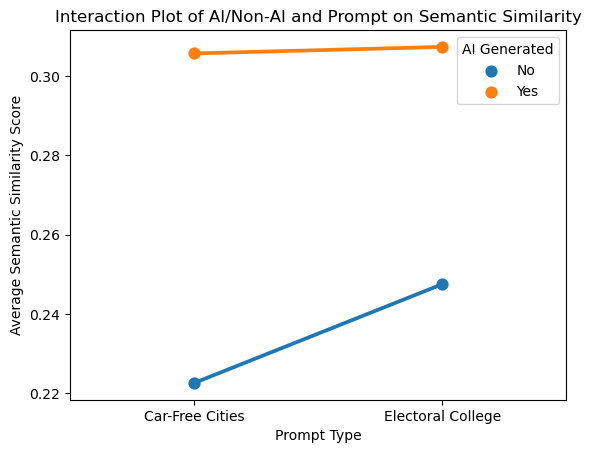

In [112]:
# Create interaction plot
interaction_plot = sns.pointplot(x='prompt_id', y='avg_semantic_similarity', hue='is_ai', data=data_df, ci=None)

# Customize the legend for 'is_ai'
# Get current handles and labels for legend
handles, labels = interaction_plot.get_legend_handles_labels()
# Define new labels for 'is_ai'
new_labels = ['No' if label == '0' else 'Yes' for label in labels[-2:]]  # Assuming last two labels are '0', '1' for is_ai
# Set new labels for legend
interaction_plot.legend(handles=handles[-2:], labels=new_labels, title='AI Generated', loc='upper right')

# Set the tick labels for 'prompt_id'
interaction_plot.set_xticklabels(['Car-Free Cities', 'Electoral College'])

# Set other plot elements
interaction_plot.set_title('Interaction Plot of AI/Non-AI and Prompt on Semantic Similarity')
interaction_plot.set_ylabel('Average Semantic Similarity Score')
interaction_plot.set_xlabel('Prompt Type')

# Show the plot
plt.show()

The interaction plot above allows us to visualize whether *is_ai* and *prompt_id* impact one another when we calculate the average semantic similarity between words score.This plot delineates the mean semantic similarity scores for each distinct group, defined by the combined categories of *is_ai*, which discriminates between AI-generated (Yes) and human-written (No) essays, and *prompt_id*, which identifies the essay prompts.

From the interaction plot, we observe parallel lines that traverse across the two essay prompts, indicating a consistent influence of AI on the semantic similarity scores. The absence of any intersection between these lines suggests that the higher average semantic similarity scores attributed to AI-generated text is consistent, showing no significant variation whether the prompt is 'Car-Free Cities' or the 'Electoral College.' The pattern underscores AI's capacity to sustain a higher degree of average semantic similarity between words (topicality), highlighting its stability in the linguistic characteristic difference irrespective of the two prompt topics.

The plot also shows us that we can infer that the AI's contribution to average semantic similarity between words score is a stable trait and not dependent on the essay prompt. Thus, the main effects of AI authorship and prompt type are generally additive where the impact of one does not necessarily depend on the other, but a formal test would overall be needed within the regression model to ascertain the presence or absence of a statistical interaction effect.

### Post-Hoc Analysis - AI vs. Human Prompt Split General Comparison - Summary
To further expand on AI vs. Human General Comparison's statistically significant results, we saw for both prompts that there is a statistically significant difference in the average semantic similarity between words score when comparing AI-generated essays to human-written essays for each prompt regardless of when we did the t-test or the linear regression model, which indicates that there is a linguistic characteristic difference in terms of whether a particular text stays on-topic to a greater degree compare to other texts regardless of the particular prompt. This further provides stronger evidence that we can consider using average semantic similarity between words score as a feature when doing an AI detection classifier in the future.

## Conclusion

In this paper, we explored average semantic similarity between words in AI-generated and human-written texts to evaluate whether a particular group's text stays on-topic to a greater degree compared to other texts. Regarding the AI vs. Human General Comparison category, we first saw that there is a statistically significant difference in average semantic similarity scores between words where AI-generated texts will have higher average scores indicating that an AI-generated text is more on-topic compared to human-written essays in general without accounting for the prompt essay sub-groups. 

Based on the evidence found in the difference in average semantic similarity scores between words for AI generated essays to human-written essays in general, we also explored in the post-hoc analysis whether there is statistically significant evidence when accounting for the different prompt essay groups in the AI vs. Human Prompt Split General Comparison. We wanted to explore the same analysis after accounting for different prompts because prompts may inherently lead to more or less semantic similarity between words for each text. 

When doing the t-test for both "Car-Free Cities" and "Electoral College" prompts, we saw that there is a difference in the average semantic similarity scores between words for AI-generated and human-written essays. This implies that the results found in AI vs. Human general comparison section is consistent across the two different prompts in our dataset. To also mitigate the potential type I error due to family-wise error rate that would need to have a correction, we performed a multiple linear regression analysis where the results are consistent to what we had seen in the earlier t-tests and how there is little interaction effect between our predictor variables.

Thus, the results from conducting the average semantic similarity between words in AI-generated and human-written texts for both AI-generated and human-written texts in general and across different prompts suggests that the difference in average semantic similarity scores between words is inherent to how AI and human convey written text. The results from this analysis further aligns with other previous research studies, such as Ma et al. (2023), who also conducted a similar study on whether semantics is a linguistic characteristic difference between human-written versus generative AI essays. As a result, we can consider using average semantic similarity between words score as a feature for AI detection to hopefully counter plagiarism and continue supporting written text from human thought.

### Future analysis considerations:
Given the analysis conducted so far, there are additional future considerations for further research:
- **Conduct a cross-analysis using different groupings:**
  - Split the data based on their generative AI model to see a deeper analysis on what subtle written text differences are associated with each generative AI model compared to human-written text. This cross-analysis can also be done on the prompts as well.
- **Calculate semantic similarity score between sentences:**
  - In this analysis, we focused specifically on calculating the semantic similarity between words. According to other research studies, there is an interest in calculating a text's average cohesion score, which is the semantic similarity score between sentences. The cohesion metric would require extrapolating the code previously found in this paper. By exploring cohesion between human-written versus generative AI essays, we can evaluate whether it is also a linguistic characteristic difference that can be used as a feature in our future AI detection classifier.
- **Use different prompts:**
  - According to the human-written essays dataset, there are additional prompts given to students to write that are not included in the public dataset. A future consideration is to acquire the additional prompts to see if there are any result differences to the prompt analysis conducted in this paper.

## References

Bašić, Ž., Banovac, A., Kružić, I., et al. (2023). ChatGPT-3.5 as writing assistance in students’ essays. Humanities & Social Sciences Communications, 10, 750. https://doi.org/10.1057/s41599-023-02269-7

Herbold, S., Hautli-Janisz, A., Heuer, U., et al. (2023). A large-scale comparison of human-written versus ChatGPT-generated essays. Scientific Reports, 13, 18617. https://doi.org/10.1038/s41598-023-45644-9

Ma, Y., Liu, J., Yi, F., Cheng, Q., Huang, Y., Lu, W., & Liu, X. (2023, February 12). AI vs. human -- differentiation analysis of Scientific Content Generation. arXiv.org. https://arxiv.org/abs/2301.10416 